**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KDTree
from sklearn import preprocessing #стандартизация
from scipy.spatial import distance #cdist
from sklearn import feature_extraction #vectorizer
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances 
from sklearn.feature_extraction.text import TfidfVectorizer

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
 
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm = 'brute', metric = 'minkowski'):
        self.n = n_neighbors
        self.alg = algorithm
        self.metric = metric
    
    def fit(self, X, y):
        self.y_train = y
        self.X_train = X
        self.min_length = np.max(self.y_train)+1
        if self.metric =="minkowski":
            self.scaler = preprocessing.StandardScaler().fit(self.X_train) 
            self.X_train_st = self.scaler.transform(self.X_train)       
        
    def predict(self, X):
        self.X_test = X
        self.y_pred = np.zeros(self.X_test.shape[0], dtype='int64')
        if self.metric == "minkowski":
            self.X_test_st = self.scaler.transform(self.X_test)
            if self.alg == 'brute':
                dist = distance.cdist(self.X_test_st, self.X_train_st, 'minkowski', p = 2.)
                ind = np.argsort(dist, axis = 1)[:,:self.n]
                self.y_pred = np.argmax(np.apply_along_axis(lambda x: np.bincount(x, minlength = self.min_length), 1, self.y_train[ind]), axis=1)
            elif self.alg == 'kd_tree':
                self.KDTree = KDTree(self.X_train_st)
                dist, ind = self.KDTree.query(self.X_test_st, k = self.n)
                self.y_pred = np.argmax(np.apply_along_axis(lambda x: np.bincount(x, minlength = self.min_length), 1, self.y_train[ind]), axis=1)
        elif self.metric == "cosine":
            dist = pairwise_distances(self.X_test, self.X_train, 'cosine')
            ind = np.argsort(dist, axis = 1)[:,:self.n]
            self.y_pred = np.argmax(np.apply_along_axis(lambda x: np.bincount(x, minlength = self.min_length), 1, self.y_train[ind]), axis=1)
        
        return self.y_pred.ravel()
        
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [8]:
#посмотрела, что в среднем точность на моем классификаторе и на sklearn не особо отличаются
my_acc=0
acc=0
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    my_acc+=accuracy_score(y_test, my_clf_pred)
    acc+=accuracy_score(y_test, sklearn_pred)
print(my_acc/100.0,acc/100.0)

0.9473333333333329 0.9466666666666664


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

Wall time: 963 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [10]:
%time my_clf.fit(X_train, y_train)

Wall time: 1 ms


In [11]:
%time clf.predict(X_test)

Wall time: 3 ms


array([1, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 1, 0, 2, 0])

In [12]:
%time my_clf.predict(X_test)

Wall time: 1 ms


array([1, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 1, 0, 2, 0], dtype=int64)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [16]:
%time my_clf.fit(X_train, y_train)

Wall time: 999 µs


In [17]:
%time clf.predict(X_test)

Wall time: 4.76 ms


array([1, 0, 0, 2, 1, 0, 1, 2, 1, 0, 1, 2, 0, 2, 2])

In [18]:
%time my_clf.predict(X_test)

Wall time: 1.99 ms


array([1, 0, 0, 2, 1, 0, 1, 2, 1, 0, 1, 2, 0, 2, 2], dtype=int64)

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [21]:
#посмотрела, что в среднем точность на моем классификаторе и на sklearn не особо отличаются
my_acc = 0
acc = 0
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.1, stratify = iris.target)
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    my_acc += accuracy_score(y_test, my_clf_pred)
    acc += accuracy_score(y_test, sklearn_pred)
print(my_acc/100.0, acc/100.0)

0.9493333333333333 0.9486666666666665


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [22]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [23]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [24]:
vectorizer = feature_extraction.text.CountVectorizer(max_df = 0.15, min_df = 0.01)
X = vectorizer.fit_transform(data)
X

<11314x1309 sparse matrix of type '<class 'numpy.int64'>'
	with 408266 stored elements in Compressed Sparse Row format>

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [25]:
#разбиение выборки на 3 блока
kfold = KFold(3,True)

In [26]:
#проверим
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]

TRAIN: [    0     1     4 ... 11309 11311 11312] TEST: [    2     3     5 ... 11305 11310 11313]
TRAIN: [    2     3     4 ... 11309 11310 11313] TEST: [    0     1    12 ... 11308 11311 11312]
TRAIN: [    0     1     2 ... 11311 11312 11313] TEST: [    4     7     8 ... 11301 11306 11309]


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [28]:
#для быстроты посчитаем на кд_дереве, хотя работает все равно очень-очень медленно т.к. для стандартизации разреженную матрицу нужно приводить к массиву
def best_k(X,n_max, my_metric = 'minkowski'):
    neigbours = list(range(1, n_max + 1, 1))
    accuracy = np.zeros(n_max)
    i = 0
    for k in neigbours:
        my_clf = MyKNeighborsClassifier(n_neighbors = k, algorithm = 'kd_tree', metric = my_metric)
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = target[train_index], target[test_index]
            my_clf.fit(X_train.toarray(), y_train)
            my_clf_pred = my_clf.predict(X_test.toarray())
            accuracy[i] += accuracy_score(y_test, my_clf_pred)
        accuracy[i] /= 3
        print(k,accuracy[i])
        i += 1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.arange(1,n_max+1)
    y = accuracy
    ax.plot(x,y)
    plt.show()
#выводим скор и лучшее кол-во соседей
    return np.argmax(accuracy[1:])+2 
#убираем из рассмотрения классификацию по одному соседу, потому что она переобучается и чувствительна к выбросам


1 0.16750102068245698
2 0.15175083126103864
3 0.14524864349520664
4 0.14524958076100736
5 0.15100551749631563
6 0.15699783266656245
7 0.15325326833957365
8 0.1535031434020424
9 0.1534967699945976
10 0.14925095591739015
11 0.14525033057364792
12 0.14474851846394884
13 0.14175076752696417
14 0.13150064127726083
15 0.13225026646466712


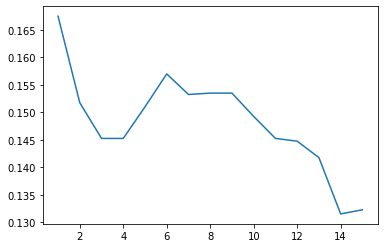

6

In [29]:
k = best_k(X[:4000],15) #проверим на первых 15 соседях и обрежем Х, чтобы побыстрее,
#но это все равно долго и упало качество,а если считать на всех, скор где то возле 0.19, но считает нереально долго
k

In [ ]:
#качество падает после 6-го соседа возможно из за того что обрезали выборку и не находится достаточное количество близких обьктов

1 0.20249222475967973
2 0.17385633266245845
3 0.1775681492936129
4 0.18667093825654454
5 0.18251759745988036
6 0.18402055124975172
7 0.18958706933408098
8 0.1830474217716478
9 0.1874677017843472
10 0.19365473461728497
11 0.18614111394477717
12 0.19047065665219276
13 0.18569883988418245
14 0.18808526382105853
15 0.18994205091993846


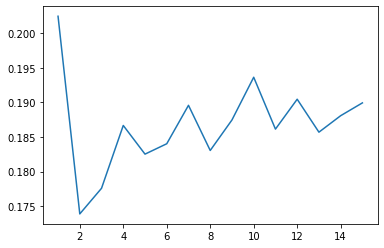

10

In [30]:
k = best_k(X,15) #проверим все-таки на всех обьектах на первых 15 соседях, нереально долго, повторять не советую
k

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [31]:
#используем косинусную метрику и перейдем на работу с разреженными матрицами с помощью pairwise_distance т.к. с косинусной метрикой нам не нужно использовать стандартизацию
my_clf2 = MyKNeighborsClassifier(n_neighbors = k, algorithm = 'brute', metric = 'cosine')
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]
    my_clf2.fit(X_train, y_train)
    my_clf2_pred = my_clf2.predict(X_test)
    print(accuracy_score(y_test, my_clf2_pred))

TRAIN: [    1     2     4 ... 11309 11310 11311] TEST: [    0     3     9 ... 11307 11312 11313]
0.4178154825026511
TRAIN: [    0     1     2 ... 11311 11312 11313] TEST: [    5     8    14 ... 11302 11303 11310]
0.41766109785202865
TRAIN: [    0     3     5 ... 11310 11312 11313] TEST: [    1     2     4 ... 11308 11309 11311]
0.43595863166268894


In [32]:
#видим, что взлетела и скорость, и точность

In [33]:
#используем Tfidf векторизацию вместе с косинусной метрикой, оставим больше фичей т.к. теперь можем себе позволить! (скорость работы гораздо выше благодаря разреженным матрицам)
vectorizer = TfidfVectorizer(max_df = 0.15, min_df = 0.001)
X2 = vectorizer.fit_transform(data)
for train_index, test_index in kfold.split(X2):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X2[train_index], X2[test_index]
    y_train, y_test = target[train_index], target[test_index]
    my_clf2.fit(X_train, y_train)
    my_clf2_pred = my_clf2.predict(X_test)
    print( accuracy_score(y_test, my_clf2_pred))

TRAIN: [    0     1     5 ... 11309 11311 11312] TEST: [    2     3     4 ... 11307 11310 11313]
0.6317603393425238
TRAIN: [    0     2     3 ... 11310 11312 11313] TEST: [    1     5     7 ... 11301 11304 11311]
0.6443914081145584
TRAIN: [    1     2     3 ... 11310 11311 11313] TEST: [    0    13    15 ... 11308 11309 11312]
0.6321930522407849


In [34]:
#точность еще увеличилась

1 0.5829945916629101
2 0.5500267431334684
3 0.5766318490378706
4 0.5967831469328494
5 0.6064171662608328
6 0.6214421110521506
7 0.6215309501855005
8 0.6306354967150377
9 0.6368222952057613
10 0.6399152374838059
11 0.6434502194802308
12 0.6377947919598873
13 0.6465437710480318
14 0.6491070530538586
15 0.6454839349507258


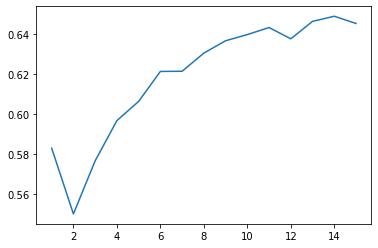

In [35]:
k = best_k(X2, 15, my_metric = 'cosine' )# найдем лучший результат по соседям на кросс валидации

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [36]:
#посмотрим качество лучшей модели на кросс-валидации
for train_index, test_index in kfold.split(X2):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X2[train_index], X2[test_index]
    y_train, y_test = target[train_index], target[test_index]
    my_clf2.fit(X_train, y_train)
    my_clf2_pred = my_clf2.predict(X_test)
    print( accuracy_score(y_test, my_clf2_pred))

TRAIN: [    0     1     2 ... 11311 11312 11313] TEST: [    4    11    12 ... 11302 11303 11306]
0.6484623541887593
TRAIN: [    0     2     3 ... 11309 11310 11311] TEST: [    1     5     7 ... 11305 11312 11313]
0.6372315035799523
TRAIN: [    1     4     5 ... 11306 11312 11313] TEST: [    0     2     3 ... 11309 11310 11311]
0.6295412357464863


In [37]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [38]:
my_clf2 = MyKNeighborsClassifier(n_neighbors = k, algorithm = 'brute',metric = 'cosine')
X2 = vectorizer.fit_transform(data) #обучаем на трейне векторайзер
my_clf2.fit(X2, target)
data_test = newsgroups_test['data'] #загружаем тест
target_test = newsgroups_test['target']
X2_test = vectorizer.transform(data_test) 
# трансформируем тест так же как обучились на трейне, здесь может упасть качество модели т.к. тест может быть сдвинут 
#относительно трейна, например, слова вообще не встречающиеся в трейне могут быть важными признаками в тесте 
#или слова очень редко встречающиеся в трейне(->имеющие большую важность) могут встречаться в тесте чаще(->должны быть менее важными)
#возможное решение - получить словарь из всего датасета(трейн+тест) и относительно него трансформировать

In [39]:
my_clf2_pred = my_clf2.predict(X2_test)
print( accuracy_score(target_test, my_clf2_pred))

0.5905469994689325


In [40]:
data_all = data + data_test
vectorizer.fit(data_all) #обучаем на всех текстах векторайзер
X2 = vectorizer.transform(data) 
my_clf2.fit(X2, target)
X2_test = vectorizer.transform(data_test) 
my_clf2_pred = my_clf2.predict(X2_test)
print( accuracy_score(target_test, my_clf2_pred))

0.5918746680828465


In [41]:
#не сильно помогло
#возможно тест как-то отличается от трейна, возможно все документы менее похожие на трейн, чем разброс внутри трейна

In [46]:
#попробуем не ограничивать снизу
vectorizer = TfidfVectorizer(max_df = 0.15)
data_all = data + data_test
vectorizer.fit(data_all) #обучаем на всех текстах векторайзер
X2 = vectorizer.transform(data) 
my_clf2.fit(X2, target)
X2_test = vectorizer.transform(data_test) 
my_clf2_pred = my_clf2.predict(X2_test)
print( accuracy_score(target_test, my_clf2_pred))

0.6171003717472119
